In [2204]:
!pip install p3_data

In [2205]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pylab as plt
import matplotlib.dates as mdates
import matplotlib.cm as cm
import seaborn as sns
import json
from io import StringIO
import importlib

In [2206]:
import p3_data
from p3_data import (glob_file_list, load_json_from_file, merge_dicts, plot_groups, 
    get_varying_column_names, filter_dataframe, take_varying_columns,
    load_json_records_as_dataframe)

In [2309]:
# Load result files from P3 Test Driver
src_files = []

# Pulsar 2.6.0 ecs s3 tier2 07.07.2020

## attempt1 brokers out of direct memory
#src_files += ['../../../../../tests/Pulsar-ecs-s3-tier2-Redhook/Pulsar-2.6.0-tier2-ecs-s3-07.07.2020-10k-16p-18tests-attempt1-broker-outofdirectmem/data/p3_test_driver/results/*.json']

## attempt2 bookies out of direct memory
#src_files += ['../../../../../tests/Pulsar-ecs-s3-tier2-Redhook/pulsar-2.6.0-tier2-ecs-s3-07.07.2020-10k-16p-19tests-attempt2-bk-outofdirectmem/data/p3_test_driver/results/*.json']

## attempt3 broker out of direct memory
#src_files += ['../../../../../tests/Pulsar-ecs-s3-tier2-Redhook/pulsar-2.6.0-tier2-ecs-s3-07.07.2020-10k-16p-19tests-attempt3-broker-directmemOOM/data/p3_test_driver/results/*.json']
#src_files += ['../../../../../tests/Pulsar-ecs-s3-tier2-Redhook/pulsar-2.6.0-tier2-ecs-s3-07.07.2020-10k-16p-19tests-attempt3-broker-directmemOOM/data/p3_test_driver/results_cleared/*.json']

# Pulsar 2.6.0 ecs s3 tier2 07.07.2020
## attempt4 broker out of direct memory - 52 tests
#src_files += ['../../../../../tests/Pulsar-ecs-s3-tier2-Redhook/pulsar-2.6.0-tier2-ecs-s3-07.07.2020-10k-16p-52tests-attempt4/data/p3_test_driver/results_cleared/*.json']

# pulsar-2.6.0-no-tiered-10.07.2020-46tests-success
################src_files += ['../../../../../tests/Pulsar-ecs-s3-tier2-Redhook/pulsar-2.6.0-no-tiered-10.07.2020-46tests-success/data/p3_test_driver/results_cleared/*.json']
#---------------------------------------------------------

### Pulsar 2.5.2 15.06.2020 44 tests different amount of workers
# src_files += ['../../../../../tests/pulsar_2.5.2_44_tests_15.06/data/p3_test_driver/results/*.json']

### Pulsar 2.5.2 17.06.2020 44 tests different amount of workers
#src_files += ['../../../../../tests/Pulsar-2.5.2-17.06.20-44tests/data/p3_test_driver/results_cleared/*.json']

#-------------------------------------------------------------------------
# Pulsar fresh tests 2.5.2 
#############src_files += ['../../../../../tests/Pulsar-ecs-s3-tier2-Redhook/Pulsar-2.5.2-no_tier2_11.07.2020/pulsar-2.5.2-10k_1p_16p_100b_1p_no_tier2_47tests-11.07.2020/data/p3_test_driver/results/*.json']



# Pravega 0.8.0-2577.15b0f5eb9 tier2 29.06.2020
#src_files += ['../../../../tests/pravega-15b0f5eb9-tier2-29.06.2020-10k-100b/pravega-0.8.0-2577.15b0f5eb9-tier2-10k-28tests-29.06.2020/data/p3_test_driver/results/*.json']

# pravega-0.8.0-2656.1c40f1e-no_netty_Isilon-nfs-tier2 09.07.2020 48 tests success
#src_files += ['../../../../../tests/Pravega-1c40f1e-NO_NETTY-nfs-Isilon-tier2-48tests-succsess-09.07.2020/data/p3_test_driver/results/*.json']

### PRAVEGA 15b0f5eb9 (master) Isilon nfs omb 2b28b32 (no_netty) 09.07.2020 48tests success
###################src_files += ['../../../../../tests/PRAVEGA-15b0f5eb9-Isilon-nfs-omb-2b28b32-09.07.2020-48tests/data/p3_test_driver/results/*.json']

###### PRAVEGA 15b0f5eb9 (master) omb 2b28b32 (no_netty) ECS S3 tier2 13.07.2020
# 10k 1p
src_files += ['../../../../../tests/PRAVEGA-15b0f5eb9-2b28b32-ECS-tier2-13.07.2020/10k-1p/data/p3_test_driver/results_cleared/*.json']
# 10k 16p and 100b 1p 16p
src_files += ['../../../../../tests/PRAVEGA-15b0f5eb9-2b28b32-ECS-tier2-13.07.2020/10k-16p-100b/data/p3_test_driver/results/*.json']

raw_df = load_json_records_as_dataframe(src=src_files, ignore_error=True)

Loading records from 44 files...


In [2310]:
# Clean raw results
def clean_result(result):
    try:
        r = result.copy()
        r['utc_begin'] = pd.to_datetime(r['utc_begin'], utc=True)
        r['utc_end'] = pd.to_datetime(r['utc_end'], utc=True)
        r['git_commit'] = r['git_commit'].split(' ')[0]
        r['driverName'] = r['driver']['name']
        if r['driverName'] == 'Pulsar':
            r = merge_dicts(r, r['driver']['client']['persistence'])
        r = merge_dicts(r, r['workload'])
        del r['workload']
        r = merge_dicts(r, r['omb_results'])
        if 'ansible_vars' in r and isinstance(r['ansible_vars'], dict):
            r = merge_dicts(r, r['ansible_vars'])
        if r['driverName'] == 'Pravega':
            if 'pravegaVersion' not in r:
                r['pravegaVersion'] = '1c40f1e-no_netty_Isilon-nfs-tier2'
            r['pravegaVersion'] = r['pravegaVersion'].replace('-SNAPSHOT','')
        for k in list(r.keys()):
            if 'Quantiles' in k:
                r[k] = pd.Series(data=[float(q) for q in r[k].keys()], index=list(r[k].values())).sort_index() / 100
            elif isinstance(r[k], list) and 'Rate' in k:
                r[k] = pd.Series(r[k])
                r['%sMean' % k] = r[k].mean()
        r['numWorkloadWorkers'] = int(r.get('numWorkers', 0))
        r['throttleEventsPerSec'] = r['producerRate']
        r['publishRateEventsPerSecMean'] = r['publishRateMean']
        r['consumeRateEventsPerSecMean'] = r['consumeRateMean']
        r['publishRateMBPerSecMean'] = r['publishRateMean'] * r['messageSize'] * 1e-6
        r['consumeRateMBPerSecMean'] = r['consumeRateMean'] * r['messageSize'] * 1e-6
        r['publishLatencyMsAvg'] = r['aggregatedPublishLatencyAvg']
        r['publishLatencyMs50Pct'] = r['aggregatedPublishLatency50pct']
        r['publishLatencyMs99Pct'] = r['aggregatedPublishLatency99pct']
        r['endToEndLatencyMsAvg'] = r['aggregatedEndToEndLatencyAvg']
        r['endToEndLatencyMs50Pct'] = r['aggregatedEndToEndLatency50pct']
        r['endToEndLatencyMs99Pct'] = r['aggregatedEndToEndLatency99pct']
        
        if r['driverName'] == 'Pulsar':
            r['version'] = r['pulsarVersion']
            
        if r['driverName'] == 'Pravega':    
            r['version'] = r['pravegaVersion']   
        
        return pd.Series(r)
    except Exception as e:
        print('ERROR: %s: %s' % (r['test_uuid'], e))
        # raise e

In [2311]:
# r = clean_result(raw_df.iloc[-1])
# pd.DataFrame(r)

In [2312]:
clean_df = raw_df.apply(clean_result, axis=1)
clean_df = clean_df.set_index('test_uuid', drop=False)
clean_df = clean_df[clean_df.error==False]
clean_df = clean_df.sort_values(['utc_begin'])

In [2313]:
# Show list of columns
clean_df.columns.values

array(['ansible', 'ansible_vars', 'aws-ec2', 'build', 'command_timed_out',
       'docker', 'driver', 'elapsed_sec', 'error', 'errors', 'exit_code',
       'git_commit', 'image', 'kubernetes', 'localWorker',
       'max_test_attempts', 'namespace', 'noop', 'numWorkers',
       'ombHelmPath', 'omb_results', 'output', 'print_output',
       'record_utc', 'record_uuid', 'result_filename', 'run_as_test',
       'sequence_in_test_batch', 'size_of_test_batch', 'status_html',
       'tarball', 'terraform', 'test', 'test_attempt', 'test_batch_uuid',
       'test_desc', 'test_driver_log_filename', 'test_driver_version',
       'test_uuid', 'undeploy', 'utc_begin', 'utc_end', 'loaded_filename',
       'driverName', 'consumerBacklogSizeGB', 'consumerPerSubscription',
       'keyDistributor', 'messageSize', 'name', 'partitionsPerTopic',
       'payloadFile', 'producerRate', 'producersPerTopic',
       'subscriptionsPerTopic', 'testDurationMinutes', 'topics',
       'aggregatedEndToEndLatency50pct'

In [2314]:
# Define columns that identify test parameters
param_cols = [
    'numWorkloadWorkers',
    'topics',
    'partitionsPerTopic',
    'producersPerTopic',
    'subscriptionsPerTopic',
    'consumerPerSubscription',
    'testDurationMinutes',
    'keyDistributor',
    'git_commit',
    'driverName',
    'version'
]

In [2315]:
# Define columns that are the output of the experiments
output_cols = [
    'publishRateEventsPerSecMean',
    'consumeRateEventsPerSecMean',
    'consumeRateMBPerSecMean',
    'publishRateMBPerSecMean',
    'publishLatencyMs50Pct',
    'publishLatencyMs99Pct',
    'endToEndLatencyMs50Pct',
    'endToEndLatencyMs99Pct',
    'throttleEventsPerSec',
    'utc_begin',    
]

In [2316]:
cols = param_cols + output_cols

In [2317]:
# View most recent results
clean_df[cols].tail(38).T

test_uuid,a86f51f4-fefd-4296-9618-6dcfba34cb44,edb371e3-0d72-429f-996d-0c8a899df654,dc528009-7866-4efd-ac9e-f02b80302841,bb854e90-d924-409f-aa83-f7b846349ec8,6ff5d178-9e6b-47ff-ae44-c0de3ea12c77,762e2936-8101-4b86-805c-3114d4b19c20,544cfb05-1fba-44c1-99af-a517d1022884,5b9207e1-ff41-4815-b6e3-4679cee971bf,c80487df-0430-4c7e-b3ba-d5b1fb3b1ba6,14b84ad4-501d-440d-abe0-ef086bfc7778,...,8611ab3a-c7dc-40f5-bbe3-c1826ea72e72,d08897e5-3f20-44be-b161-bc3800794cb6,d8f955f6-d05c-4735-9982-42a01b0d1241,4ed74224-67ce-4283-a428-ed66794d3ed7,0b5a4f0d-7152-44af-a917-2e687ba55c7b,836b2aac-fb7e-44af-9fab-a5cc1b66ee8d,2135925a-5b50-45a4-bd22-5673cbc10ef1,7b7f804f-2974-4d00-8ad7-9cbf6e537847,9280429e-35cc-4275-8c8e-024ab090e31c,b9df2974-c8de-4e9b-8c00-6424f1d78c30
numWorkloadWorkers,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
topics,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
partitionsPerTopic,1,1,1,16,16,16,16,16,16,16,...,1,1,1,1,1,1,1,1,1,1
producersPerTopic,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
subscriptionsPerTopic,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
consumerPerSubscription,4,4,4,4,4,4,4,4,4,4,...,4,4,4,4,4,4,4,4,4,4
testDurationMinutes,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
keyDistributor,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,...,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY,NO_KEY
git_commit,36327d9,36327d9,36327d9,43ca84e,43ca84e,43ca84e,43ca84e,43ca84e,43ca84e,43ca84e,...,b023619,b023619,b023619,b023619,b023619,b023619,b023619,b023619,b023619,b023619
driverName,Pravega,Pravega,Pravega,Pravega,Pravega,Pravega,Pravega,Pravega,Pravega,Pravega,...,Pravega,Pravega,Pravega,Pravega,Pravega,Pravega,Pravega,Pravega,Pravega,Pravega


In [2318]:
# Export to CSV
#clean_df[cols].to_csv('openmessaging-benchmark-results.csv')

In [2319]:
# df = clean_df[cols]
# df = df.sort_values(['messageSize','numWorkloadWorkers','producersPerTopic','throttleEventsPerSec','utc_begin'])
# df.head()

In [2320]:
# View distinct values of pravegaVersion and test counts
clean_df.groupby(['version']).size()

version
15b0f5eb9-no_netty-2b28b32-ECS-S3-tier2    44
dtype: int64

In [2321]:
# First level of filtering
filt_df = filter_dataframe(
    clean_df,
    #version='2.6.0-not-tiered',
    #driverName='Pulsar',
    #pulsarVersion='2.5.2',
    #pravegaVersion='0.8.0-2656.15b0f5eb9-no_netty-client-Isilon-tier2',
    numWorkloadWorkers=4, 
    topics=4,
    testDurationMinutes=2,
   # size_of_test_batch=(2,1000), # between
   # aggregatedEndToEndLatency50pct=(1,1e6),
)
# filt_df = filt_df[filt_df.size_of_test_batch > 1]
len(filt_df)

44

In [2322]:
def latency_vs_publish_throughput_table(df):
    result_df = (df
        .set_index(['publishRateMBPerSecMean'])
        .sort_index()
        [[
            'aggregatedPublishLatency50pct',
            'aggregatedPublishLatency95pct',
            'aggregatedPublishLatency99pct',
            'aggregatedEndToEndLatency50pct',
            'aggregatedEndToEndLatency95pct',
            'aggregatedEndToEndLatency99pct',
            'test_uuid',
        ]]
        .rename(columns=dict(
            aggregatedPublishLatency50pct='Publish Latency p50',
            aggregatedPublishLatency95pct='Publish Latency p95',
            aggregatedPublishLatency99pct='Publish Latency p99',
            aggregatedEndToEndLatency50pct='E2E Latency p50',
            aggregatedEndToEndLatency95pct='E2E Latency p95',
            aggregatedEndToEndLatency99pct='E2E Latency p99',
        ))
        )
    result_df.index.name = 'Achieved Publish Throughput (MB/s)'
    return result_df

In [2323]:
def latency_vs_consume_throughput_table(df):
    result_df = (df
        .set_index(['consumeRateMBPerSecMean'])
        .sort_index()
        [[
            'aggregatedPublishLatency50pct',
            'aggregatedPublishLatency95pct',
            'aggregatedPublishLatency99pct',
            'aggregatedEndToEndLatency50pct',
            'aggregatedEndToEndLatency95pct',
            'aggregatedEndToEndLatency99pct',
            'test_uuid',
        ]]
        .rename(columns=dict(
            aggregatedPublishLatency50pct='Publish Latency p50',
            aggregatedPublishLatency95pct='Publish Latency p95',
            aggregatedPublishLatency99pct='Publish Latency p99',
            aggregatedEndToEndLatency50pct='E2E Latency p50',
            aggregatedEndToEndLatency95pct='E2E Latency p95',
            aggregatedEndToEndLatency99pct='E2E Latency p99',
        ))
        )
    result_df.index.name = 'Achieved Consume Throughput (MB/s)'
    return result_df

In [2324]:
def latency_vs_provided_rate_table(df):
    result_df = (df
        .set_index(['throttleEventsPerSec'])
        .sort_index()
        [[
            'aggregatedPublishLatency50pct',
            'aggregatedPublishLatency95pct',
            'aggregatedPublishLatency99pct',
            'aggregatedEndToEndLatency50pct',
            'aggregatedEndToEndLatency95pct',
            'aggregatedEndToEndLatency99pct',
            'test_uuid',
        ]]
        .rename(columns=dict(
            aggregatedPublishLatency50pct='Publish Latency p50',
            aggregatedPublishLatency95pct='Publish Latency p95',
            aggregatedPublishLatency99pct='Publish Latency p99',
            aggregatedEndToEndLatency50pct='E2E Latency p50',
            aggregatedEndToEndLatency95pct='E2E Latency p95',
            aggregatedEndToEndLatency99pct='E2E Latency p99',
        ))
        )
    result_df.index.name = 'Throttle Events Per Second'
    return result_df

In [2325]:
def plot_latency_vs_consume_throughput(df):
    assert len(df.messageSize.drop_duplicates().values) == 1
    messageSize = df.messageSize.iloc[0]
    partitionsPerTopic = df.partitionsPerTopic.iloc[0]
    testDurationMinutes = df.testDurationMinutes.iloc[0]
    topics = df.topics.iloc[0]
    producersPerTopic = df.producersPerTopic.iloc[0]
    consumerPerSubscription = df.consumerPerSubscription.iloc[0]
    version = df.version.iloc[0]
    driver = df.driver.iloc[0]
    plot_df = latency_vs_consume_throughput_table(df)
    title = '%s %s , message Size %d, partitions: %d producersPerTopic: %d consumerPerSubscription: %d topics: %d  %dmin test' % (driver, version, messageSize, partitionsPerTopic, producersPerTopic, consumerPerSubscription, topics, testDurationMinutes)
    ax = plot_df.plot(
        logx=True, 
        logy=True,
        figsize=(10,8),
        grid=True, 
        title=title, 
        style=['x:b','x-.b','x-b','+:r','+-.r','+-r'])
    ax.set_ylabel('Latency (ms)');
    tick_formatter = matplotlib.ticker.LogFormatter()
    ax.xaxis.set_major_formatter(tick_formatter)
    ax.yaxis.set_major_formatter(tick_formatter)
    ax.grid('on', which='both', axis='both')

In [2326]:
def plot_latency_vs_publish_throughput(df):
    assert len(df.messageSize.drop_duplicates().values) == 1
    messageSize = df.messageSize.iloc[0]
    partitionsPerTopic = df.partitionsPerTopic.iloc[0]
    testDurationMinutes = df.testDurationMinutes.iloc[0]
    topics = df.topics.iloc[0]
    producersPerTopic = df.producersPerTopic.iloc[0]
    consumerPerSubscription = df.consumerPerSubscription.iloc[0]
    version = df.version.iloc[0]
    driver = df.driver.iloc[0]
    plot_df = latency_vs_publish_throughput_table(df)
    title = '%s %s , message Size %d, partitions: %d producersPerTopic: %d consumerPerSubscription: %d topics: %d  %dmin test' % (driver, version, messageSize, partitionsPerTopic, producersPerTopic, consumerPerSubscription, topics, testDurationMinutes)
    ax = plot_df.plot(
        logx=True, 
        logy=True,
        figsize=(10,8),
        grid=True, 
        title=title, 
        style=['x:b','x-.b','x-b','+:r','+-.r','+-r'])
    ax.set_ylabel('Latency (ms)');
    tick_formatter = matplotlib.ticker.LogFormatter()
    ax.xaxis.set_major_formatter(tick_formatter)
    ax.yaxis.set_major_formatter(tick_formatter)
    ax.grid('on', which='both', axis='both')

In [2327]:
def plot_latency_vs_provided_rate(df):
    assert len(df.messageSize.drop_duplicates().values) == 1
    messageSize = df.messageSize.iloc[0]
    partitionsPerTopic = df.partitionsPerTopic.iloc[0]
    testDurationMinutes = df.testDurationMinutes.iloc[0]
    topics = df.topics.iloc[0]
    producersPerTopic = df.producersPerTopic.iloc[0]
    consumerPerSubscription = df.consumerPerSubscription.iloc[0]
    version = df.version.iloc[0]
    driver = df.driver.iloc[0]
    plot_df = latency_vs_provided_rate_table(df)
    title = '%s %s, message Size %d, partitions: %d producersPerTopic: %d consumerPerSubscription: %d topics: %d  %dmin test' % (driver, version, messageSize, partitionsPerTopic, producersPerTopic, consumerPerSubscription, topics, testDurationMinutes)
    ax = plot_df.plot(
        logx=True, 
        logy=True,
        figsize=(10,8),
        grid=True, 
        title=title, 
        style=['x:b','x-.b','x-b','+:r','+-.r','+-r'])
    ax.set_ylabel('Latency (ms)');
    tick_formatter = matplotlib.ticker.LogFormatter()
    ax.xaxis.set_major_formatter(tick_formatter)
    ax.yaxis.set_major_formatter(tick_formatter)
    ax.grid('on', which='both', axis='both')

In [2328]:
def plot_latency_vs_provided_rate_normal(df):
    assert len(df.messageSize.drop_duplicates().values) == 1
    messageSize = df.messageSize.iloc[0]
    partitionsPerTopic = df.partitionsPerTopic.iloc[0]
    testDurationMinutes = df.testDurationMinutes.iloc[0]
    topics = df.topics.iloc[0]
    producersPerTopic = df.producersPerTopic.iloc[0]
    consumerPerSubscription = df.consumerPerSubscription.iloc[0]
    version = df.version.iloc[0]
    driver = df.driver.iloc[0]
    plot_df = latency_vs_provided_rate_table(df)
    title = '%s %s , message Size %d, partitions: %d producersPerTopic: %d consumerPerSubscription: %d topics: %d  %dmin test' % (driver, version, messageSize, partitionsPerTopic, producersPerTopic, consumerPerSubscription, topics, testDurationMinutes)
    ax = plot_df.plot(
        logx=False, 
        logy=False,
        figsize=(10,8),
        grid=True, 
        title=title, 
        style=['x:b','x-.b','x-b','+:r','+-.r','+-r'])
    ax.set_ylabel('Latency (ms)');
    tick_formatter = matplotlib.ticker.LogFormatter()
    ax.xaxis.set_major_formatter(tick_formatter)
    ax.yaxis.set_major_formatter(tick_formatter)
    ax.grid('on', which='both', axis='both')

## Message Size 100 B

In [2347]:
filt_100_df = filter_dataframe(
    filt_df,
    messageSize=100,
    producersPerTopic=4,
    partitionsPerTopic=1,
    version='15b0f5eb9-no_netty-2b28b32-ECS-S3-tier2',
    #version='0.8.0-2656.15b0f5eb9-no_netty-client-Isilon-tier2',
    #version='2.6.0-not-tiered',
    #version='2.5.2',
    topics=4
)

In [2348]:
# View varying columns
take_varying_columns(filt_100_df[filt_100_df.producerRate==100000]).T

test_uuid


In [2349]:
# View distinct sets of parameters.
# There should only be one distinct set of parameters.
filt_100_df[param_cols].drop_duplicates().T

test_uuid,7bb5f7d4-9f6f-471b-9a25-91aa848126ae
numWorkloadWorkers,4
topics,4
partitionsPerTopic,1
producersPerTopic,4
subscriptionsPerTopic,1
consumerPerSubscription,4
testDurationMinutes,2
keyDistributor,NO_KEY
git_commit,b023619
driverName,Pravega


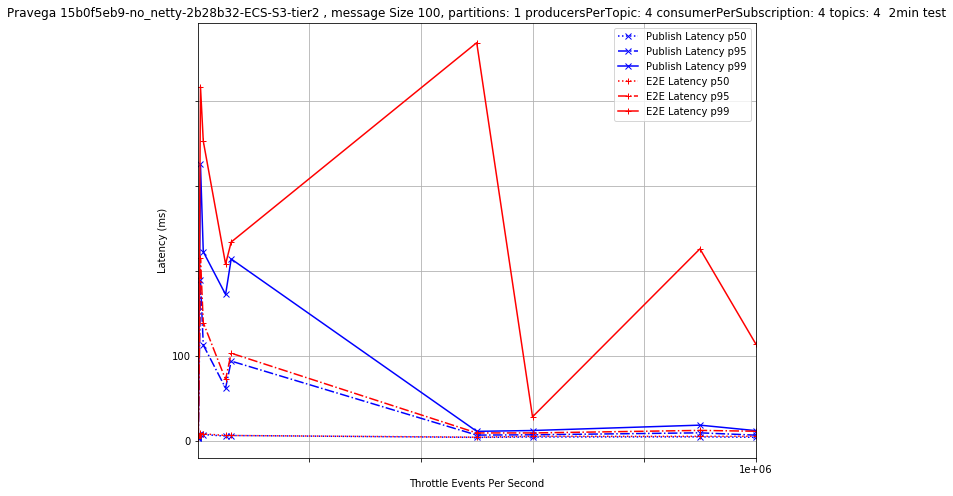

In [2350]:
plot_latency_vs_provided_rate_normal(filt_100_df)

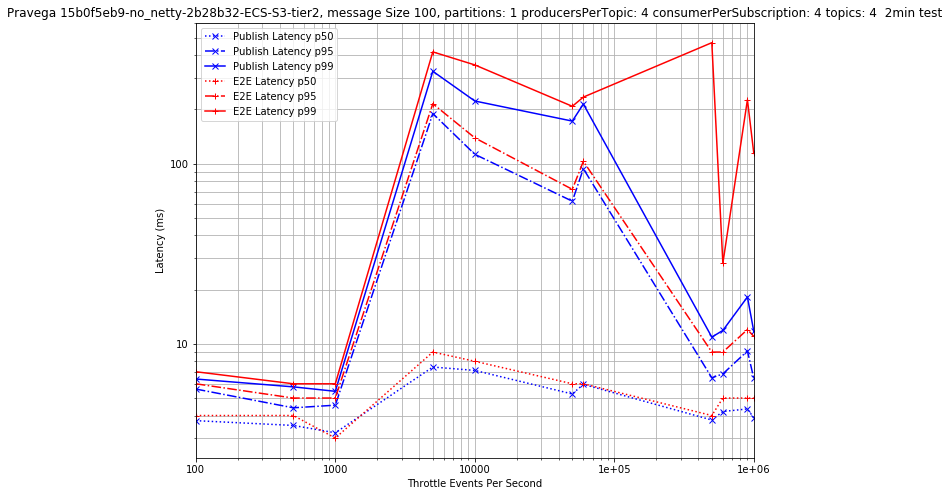

In [2351]:
plot_latency_vs_provided_rate(filt_100_df)

In [2352]:
latency_vs_provided_rate_table(filt_100_df)

,Publish Latency p50,Publish Latency p95,Publish Latency p99,E2E Latency p50,E2E Latency p95,E2E Latency p99,test_uuid
Throttle Events Per Second,,,,,,,
100.0,3.746,5.610,6.378,4.0,6.0,7.000,8611ab3a-c7dc-40f5-bbe3-c1826ea72e72
500.0,3.524,4.414,5.769,4.0,5.0,6.000,d8f955f6-d05c-4735-9982-42a01b0d1241
1000.0,3.208,4.565,5.450,3.0,5.0,6.000,0b5a4f0d-7152-44af-a917-2e687ba55c7b
5000.0,7.433,189.557,325.491,9.0,215.0,417.001,9280429e-35cc-4275-8c8e-024ab090e31c
10000.0,7.118,112.640,222.589,8.0,139.0,353.001,2135925a-5b50-45a4-bd22-5673cbc10ef1
50000.0,5.269,61.868,172.200,6.0,72.0,208.000,b9df2974-c8de-4e9b-8c00-6424f1d78c30
60000.0,5.960,93.700,214.077,6.0,103.0,234.000,7b7f804f-2974-4d00-8ad7-9cbf6e537847
500000.0,3.776,6.476,10.897,4.0,9.0,469.001,4ed74224-67ce-4283-a428-ed66794d3ed7
600000.0,4.210,6.810,11.863,5.0,9.0,28.000,836b2aac-fb7e-44af-9fab-a5cc1b66ee8d


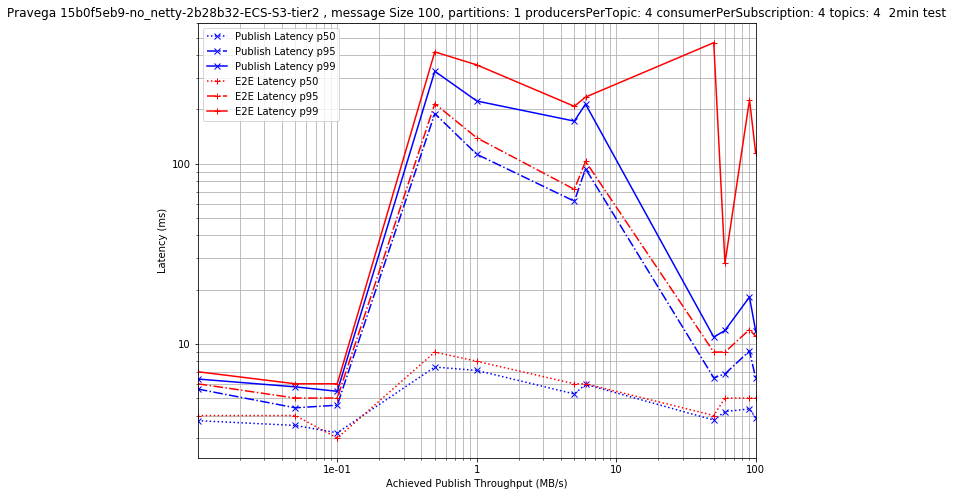

In [2353]:
plot_latency_vs_publish_throughput(filt_100_df)

In [2354]:
latency_vs_publish_throughput_table(filt_100_df)

,Publish Latency p50,Publish Latency p95,Publish Latency p99,E2E Latency p50,E2E Latency p95,E2E Latency p99,test_uuid
Achieved Publish Throughput (MB/s),,,,,,,
0.010013,3.746,5.610,6.378,4.0,6.0,7.000,8611ab3a-c7dc-40f5-bbe3-c1826ea72e72
0.050059,3.524,4.414,5.769,4.0,5.0,6.000,d8f955f6-d05c-4735-9982-42a01b0d1241
0.100169,3.208,4.565,5.450,3.0,5.0,6.000,0b5a4f0d-7152-44af-a917-2e687ba55c7b
0.501075,7.433,189.557,325.491,9.0,215.0,417.001,9280429e-35cc-4275-8c8e-024ab090e31c
1.002336,7.118,112.640,222.589,8.0,139.0,353.001,2135925a-5b50-45a4-bd22-5673cbc10ef1
5.013866,5.269,61.868,172.200,6.0,72.0,208.000,b9df2974-c8de-4e9b-8c00-6424f1d78c30
6.032567,5.960,93.700,214.077,6.0,103.0,234.000,7b7f804f-2974-4d00-8ad7-9cbf6e537847
50.079304,3.776,6.476,10.897,4.0,9.0,469.001,4ed74224-67ce-4283-a428-ed66794d3ed7
60.266978,4.210,6.810,11.863,5.0,9.0,28.000,836b2aac-fb7e-44af-9fab-a5cc1b66ee8d


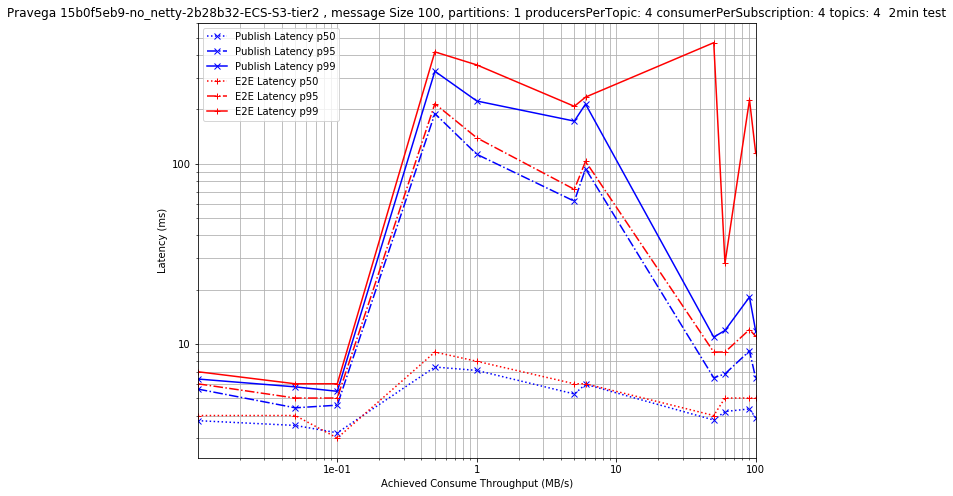

In [2355]:
plot_latency_vs_consume_throughput(filt_100_df)

In [2356]:
latency_vs_consume_throughput_table(filt_100_df)

,Publish Latency p50,Publish Latency p95,Publish Latency p99,E2E Latency p50,E2E Latency p95,E2E Latency p99,test_uuid
Achieved Consume Throughput (MB/s),,,,,,,
0.010011,3.746,5.610,6.378,4.0,6.0,7.000,8611ab3a-c7dc-40f5-bbe3-c1826ea72e72
0.050058,3.524,4.414,5.769,4.0,5.0,6.000,d8f955f6-d05c-4735-9982-42a01b0d1241
0.100170,3.208,4.565,5.450,3.0,5.0,6.000,0b5a4f0d-7152-44af-a917-2e687ba55c7b
0.501633,7.433,189.557,325.491,9.0,215.0,417.001,9280429e-35cc-4275-8c8e-024ab090e31c
1.002327,7.118,112.640,222.589,8.0,139.0,353.001,2135925a-5b50-45a4-bd22-5673cbc10ef1
5.013619,5.269,61.868,172.200,6.0,72.0,208.000,b9df2974-c8de-4e9b-8c00-6424f1d78c30
6.034079,5.960,93.700,214.077,6.0,103.0,234.000,7b7f804f-2974-4d00-8ad7-9cbf6e537847
50.080362,3.776,6.476,10.897,4.0,9.0,469.001,4ed74224-67ce-4283-a428-ed66794d3ed7
60.266505,4.210,6.810,11.863,5.0,9.0,28.000,836b2aac-fb7e-44af-9fab-a5cc1b66ee8d


## Message Size 10 KB

In [2339]:
filt_10000_df = filter_dataframe(
    filt_df,
    messageSize=10000,
    producersPerTopic=4,
    partitionsPerTopic=1,
    numWorkloadWorkers=4,
    #version='2.6.0-not-tiered'
    #version='2.5.2',
    #version='0.8.0-2656.15b0f5eb9-no_netty-client-Isilon-tier2'
    version='15b0f5eb9-no_netty-2b28b32-ECS-S3-tier2'
)

In [2340]:
# View distinct sets of parameters.
# There should only be one distinct set of parameters.
filt_10000_df[param_cols].drop_duplicates().T

test_uuid,ea38528f-b44a-411b-ab21-05df7ab46bba
numWorkloadWorkers,4
topics,4
partitionsPerTopic,1
producersPerTopic,4
subscriptionsPerTopic,1
consumerPerSubscription,4
testDurationMinutes,2
keyDistributor,NO_KEY
git_commit,36327d9
driverName,Pravega


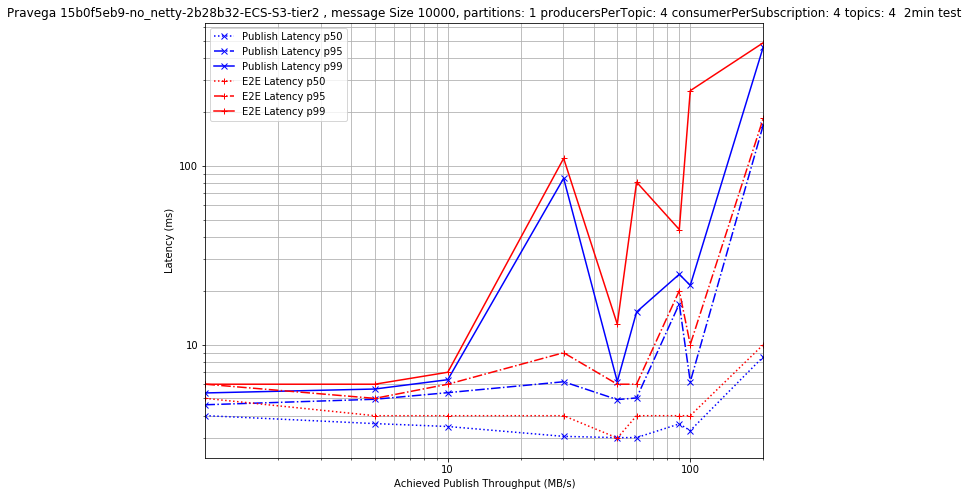

In [2341]:
plot_latency_vs_publish_throughput(filt_10000_df)

In [2342]:
latency_vs_publish_throughput_table(filt_10000_df)

,Publish Latency p50,Publish Latency p95,Publish Latency p99,E2E Latency p50,E2E Latency p95,E2E Latency p99,test_uuid
Achieved Publish Throughput (MB/s),,,,,,,
1.001562,4.003,4.605,5.362,5.0,6.0,6.000,ea38528f-b44a-411b-ab21-05df7ab46bba
5.005481,3.613,4.943,5.639,4.0,5.0,6.000,f22cf293-8453-4b3a-9111-6d38ba65a6fd
10.014787,3.480,5.382,6.360,4.0,6.0,7.000,edab4c5c-b5d3-4b88-92a5-24aec67ad3dd
30.087920,3.065,6.194,85.131,4.0,9.0,110.000,642396d8-fcba-4e84-a935-a0c642a95b6b
50.075737,3.016,4.922,6.208,3.0,6.0,13.000,a86f51f4-fefd-4296-9618-6dcfba34cb44
60.155225,3.017,5.028,15.226,4.0,6.0,81.000,e95c2eec-dad4-4fbc-bf7a-1e7e9ed17a6b
90.238519,3.599,16.895,24.720,4.0,20.0,44.000,edb371e3-0d72-429f-996d-0c8a899df654
100.148651,3.301,6.190,21.425,4.0,10.0,263.001,09fe3ce4-1ea2-4c2f-a41a-5998a9e70027
200.534677,8.559,169.670,463.901,10.0,185.0,488.001,dc528009-7866-4efd-ac9e-f02b80302841


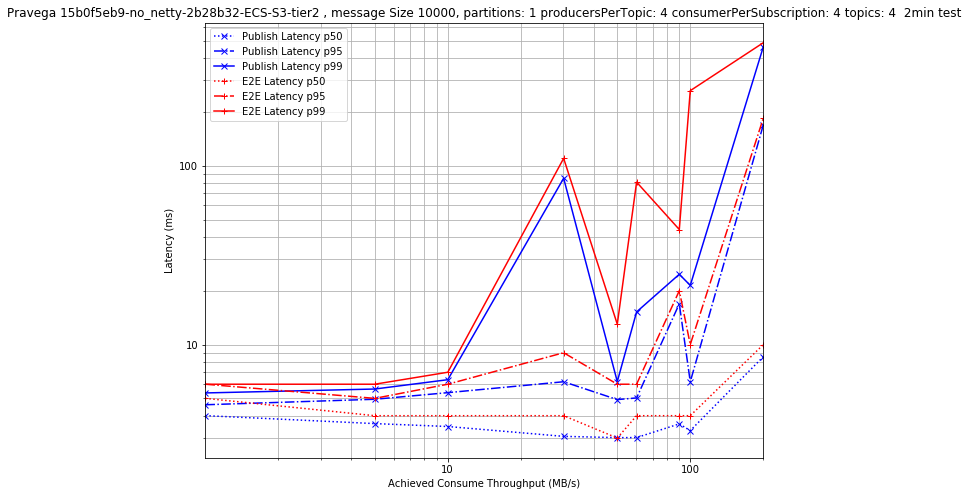

In [2343]:
plot_latency_vs_consume_throughput(filt_10000_df)

In [2344]:
latency_vs_consume_throughput_table(filt_10000_df)

,Publish Latency p50,Publish Latency p95,Publish Latency p99,E2E Latency p50,E2E Latency p95,E2E Latency p99,test_uuid
Achieved Consume Throughput (MB/s),,,,,,,
1.001480,4.003,4.605,5.362,5.0,6.0,6.000,ea38528f-b44a-411b-ab21-05df7ab46bba
5.005646,3.613,4.943,5.639,4.0,5.0,6.000,f22cf293-8453-4b3a-9111-6d38ba65a6fd
10.015117,3.480,5.382,6.360,4.0,6.0,7.000,edab4c5c-b5d3-4b88-92a5-24aec67ad3dd
30.087923,3.065,6.194,85.131,4.0,9.0,110.000,642396d8-fcba-4e84-a935-a0c642a95b6b
50.075327,3.016,4.922,6.208,3.0,6.0,13.000,a86f51f4-fefd-4296-9618-6dcfba34cb44
60.156219,3.017,5.028,15.226,4.0,6.0,81.000,e95c2eec-dad4-4fbc-bf7a-1e7e9ed17a6b
90.239856,3.599,16.895,24.720,4.0,20.0,44.000,edb371e3-0d72-429f-996d-0c8a899df654
100.146012,3.301,6.190,21.425,4.0,10.0,263.001,09fe3ce4-1ea2-4c2f-a41a-5998a9e70027
200.533672,8.559,169.670,463.901,10.0,185.0,488.001,dc528009-7866-4efd-ac9e-f02b80302841


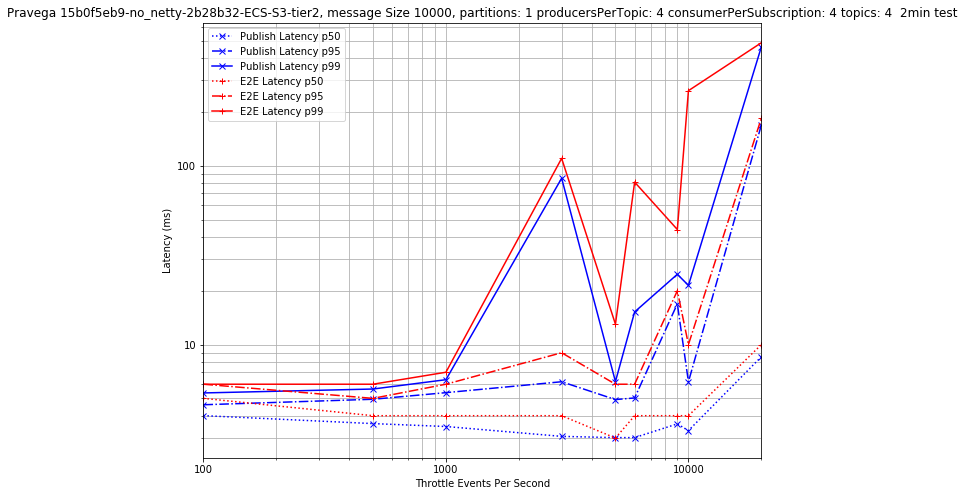

In [2345]:
plot_latency_vs_provided_rate(filt_10000_df)

In [2346]:
latency_vs_provided_rate_table(filt_10000_df)

,Publish Latency p50,Publish Latency p95,Publish Latency p99,E2E Latency p50,E2E Latency p95,E2E Latency p99,test_uuid
Throttle Events Per Second,,,,,,,
100.0,4.003,4.605,5.362,5.0,6.0,6.000,ea38528f-b44a-411b-ab21-05df7ab46bba
500.0,3.613,4.943,5.639,4.0,5.0,6.000,f22cf293-8453-4b3a-9111-6d38ba65a6fd
1000.0,3.480,5.382,6.360,4.0,6.0,7.000,edab4c5c-b5d3-4b88-92a5-24aec67ad3dd
3000.0,3.065,6.194,85.131,4.0,9.0,110.000,642396d8-fcba-4e84-a935-a0c642a95b6b
5000.0,3.016,4.922,6.208,3.0,6.0,13.000,a86f51f4-fefd-4296-9618-6dcfba34cb44
6000.0,3.017,5.028,15.226,4.0,6.0,81.000,e95c2eec-dad4-4fbc-bf7a-1e7e9ed17a6b
9000.0,3.599,16.895,24.720,4.0,20.0,44.000,edb371e3-0d72-429f-996d-0c8a899df654
10000.0,3.301,6.190,21.425,4.0,10.0,263.001,09fe3ce4-1ea2-4c2f-a41a-5998a9e70027
20000.0,8.559,169.670,463.901,10.0,185.0,488.001,dc528009-7866-4efd-ac9e-f02b80302841


## Analyze 100 B events, 50,000 events/sec, various number of partitions and producers

In [2245]:
filt_50000eps_df = filter_dataframe(
    filt_df,
    messageSize=100,
    producerRate=-1,
).sort_values(['endToEndLatencyMs99Pct'], ascending=True)
len(filt_50000eps_df)

filter_dataframe: No matching records after filtering on producerRate=[-1]


0

In [2246]:
take_varying_columns(filt_50000eps_df[cols]).head(20)

""
test_uuid


# Analyze Latency Distribution

In [2247]:
test_uuid = filt_50000eps_df.iloc[0].name
test_uuid

IndexError: single positional indexer is out-of-bounds

In [2248]:
df = clean_df
t = df[df.test_uuid==test_uuid].iloc[0]

IndexError: single positional indexer is out-of-bounds

In [2249]:
# Cumulative Distribution Function
pubcdf = t.aggregatedPublishLatencyQuantiles
pubcdf.name = 'Publish Latency CDF'

In [2250]:
# Probability Distribution Function (latency histogram)
pubpdf = pd.Series(index=pubcdf.index, data=np.gradient(pubcdf, pubcdf.index.values), name='Publish Latency PDF')

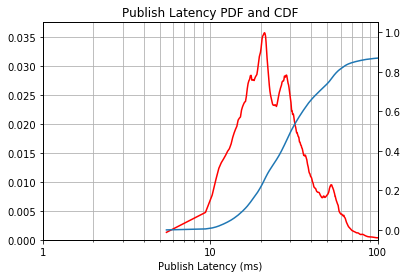

In [2251]:
fig0, ax0 = plt.subplots()
ax1 = ax0.twinx()
pubpdf.plot(ax=ax0, xlim=[1,100], ylim=[0,None], style='r', title='Publish Latency PDF and CDF')
pubcdf.plot(ax=ax1, xlim=[1,100], secondary_y=True, logx=True, ylim=[0,1])
# ax0.set_ylabel('PDF');
# ax1.set_ylabel('CDF');
ax0.set_xlabel('Publish Latency (ms)');
tick_formatter = matplotlib.ticker.LogFormatter()
ax0.xaxis.set_major_formatter(tick_formatter)
ax0.grid('on', which='both', axis='both')
plt.show()
plt.close()

In [2252]:
# Cumulative Distribution Function
e2ecdf = t.aggregatedEndToEndLatencyQuantiles
e2ecdf.name = 'E2E Latency CDF'
# Probability Distribution Function (latency histogram)
e2epdf = pd.Series(index=e2ecdf.index, data=np.gradient(e2ecdf, e2ecdf.index.values), name='E2E Latency PDF')

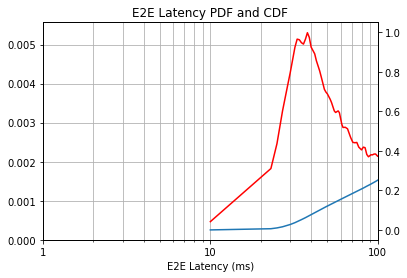

In [2253]:
fig0, ax0 = plt.subplots()
ax1 = ax0.twinx()
e2epdf.plot(ax=ax0, xlim=[1,100], ylim=[0,None], style='r', title='E2E Latency PDF and CDF')
e2ecdf.plot(ax=ax1, xlim=[1,100], secondary_y=True, logx=True, ylim=[0,1])
# ax0.set_ylabel('PDF');
# ax1.set_ylabel('CDF');
ax0.set_xlabel('E2E Latency (ms)');
tick_formatter = matplotlib.ticker.LogFormatter()
ax0.xaxis.set_major_formatter(tick_formatter)
ax0.grid('on', which='both', axis='both')
plt.show()
plt.close()

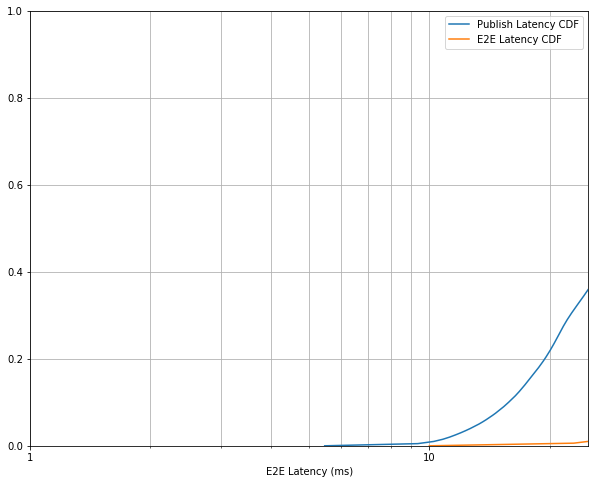

In [2254]:
# Combined publish and E2E latency CDF
fig0, ax0 = plt.subplots()
xlim=[1,25]
pubcdf.plot(ax=ax0, xlim=xlim, logx=True, ylim=[0,1], legend=True, figsize=(10,8))
e2ecdf.plot(ax=ax0, xlim=xlim, logx=True, ylim=[0,1], legend=True)
ax0.set_xlabel('E2E Latency (ms)');
tick_formatter = matplotlib.ticker.LogFormatter()
ax0.xaxis.set_major_formatter(tick_formatter)
ax0.grid('on', which='both', axis='both')
plt.show()
plt.close()

## Compare Two Sets

In [2277]:
# Common filter
filt_df = filter_dataframe(
    clean_df,
    numWorkloadWorkers=4, 
    topics=4,
    testDurationMinutes=2,
    #size_of_test_batch=(2,1000), # between
    #aggregatedEndToEndLatency50pct=(1,1e6),
    messageSize=10000,
    producersPerTopic=4,
    partitionsPerTopic=1,    
)
len(filt_df)

46

In [2278]:
# Set 1
filt1_df = filter_dataframe(
    filt_df,
    #version='2.6.0-not-tiered',
    version='15b0f5eb9-no_netty-2b28b32-ECS-S3-tier2',
    #pravegaVersion='0.8.0-2656.15b0f5eb9-no_netty-client-Isilon-tier2' 
    #pravegaVersion='0.8.0-2656.1c40f1e-Isilon-tier2',
)
len(filt1_df)

9

In [2279]:
# Set 2
filt2_df = filter_dataframe(
    filt_df,
    #version='2.6.0-ecs-s3-tier2'
    #version='2.5.2',
    #pravegaVersion='0.8.0-2656.1c40f1e-Isilon-tier2',
    pravegaVersion='0.8.0-2656.15b0f5eb9-no_netty-client-Isilon-tier2'
)
len(filt2_df)

13

In [2280]:
dfs = [filt1_df, filt2_df]
take_varying_columns(pd.concat(dfs)[param_cols]).drop_duplicates()

,git_commit,version
test_uuid,,
ea38528f-b44a-411b-ab21-05df7ab46bba,36327d9,15b0f5eb9-no_netty-2b28b32-ECS-S3-tier2
5afc1c15-1721-4aba-9d29-c959d9320c74,88dbf86,0.8.0-2656.15b0f5eb9-no_netty-client-Isilon-tier2


In [2281]:
def plot_latency_vs_throughput_comparison(dfs, legend_cols=None, latencyMetric='Publish'):
    fig0, ax0 = plt.subplots()
    cmap = plt.get_cmap('Set1')
    colors = cmap.colors[0:len(dfs)]
    pravegaVersion = filt1_df.version.iloc[0]
    pravegaDriver = filt1_df.driver.iloc[0]
    pulsarVersion = filt2_df.version.iloc[0]
    pulsaraDriver = filt2_df.driver.iloc[0]
    messageSize = filt2_df.messageSize.iloc[0]
    msgSize = '%db' % (messageSize)
    if messageSize >= 1000:
        msgSize = '%dk' % (messageSize/1000)
    
    partitionsPerTopic = filt2_df.partitionsPerTopic.iloc[0]
    testDurationMinutes = filt2_df.testDurationMinutes.iloc[0]
    topics = filt2_df.topics.iloc[0]
    producersPerTopic = filt2_df.producersPerTopic.iloc[0]
    consumerPerSubscription = filt2_df.consumerPerSubscription.iloc[0]
    
    title = 'Compare %s %s and %s %s [messageSize %s, partitions: %d producersPerTopic: %d consumerPerSubscription: %d topics: %d] on %d min test' % (pravegaDriver, pravegaVersion, pulsaraDriver, pulsarVersion, msgSize, partitionsPerTopic, producersPerTopic, consumerPerSubscription, topics, testDurationMinutes)
   
    for index, (df, color) in enumerate(zip(dfs, colors)):
        df = df.set_index(['publishRateMBPerSecMean']).sort_index()
        name_cols = df.iloc[0][legend_cols]
        name = ','.join(['%s=%s' % item for item in name_cols.to_dict().items()])
    
        plot_df = latency_vs_provided_rate_table(df)
        
        for percentile, style in [('50',':x'), ('95','-.x'), ('99','-x')]:
            plot_df = df[['aggregated%sLatency%spct' % (latencyMetric, percentile)]]
            plot_df.columns = ['%s %s Latency p%s' % (name, latencyMetric, percentile)]
            plot_df.index.name = 'Achieved Publish Throughput (MB/s)'
            plot_df.plot(
                ax=ax0,
                logx=True, 
                logy=True,
                figsize=(10,8),
                grid=True,
                style=style,
                color=color,
                title=title 
            )
    ax0.set_ylabel('Latency (ms)');
    tick_formatter = matplotlib.ticker.LogFormatter()
    ax0.xaxis.set_major_formatter(tick_formatter)
    ax0.yaxis.set_major_formatter(tick_formatter)
    ax0.grid('on', which='both', axis='both')

In [2282]:
def plot_latency_vs_provided_rate_comparison(dfs, legend_cols=None, latencyMetric='Publish'):
    fig0, ax0 = plt.subplots()
    cmap = plt.get_cmap('Set1')
    colors = cmap.colors[0:len(dfs)]
    pravegaVersion = filt1_df.version.iloc[0]
    pravegaDriver = filt1_df.driver.iloc[0]
    pulsarVersion = filt2_df.version.iloc[0]
    pulsaraDriver = filt2_df.driver.iloc[0]
    messageSize = filt2_df.messageSize.iloc[0]
    msgSize = '%db' % (messageSize)
    if messageSize >= 1000:
        msgSize = '%dk' % (messageSize/1000)
    
    partitionsPerTopic = filt2_df.partitionsPerTopic.iloc[0]
    testDurationMinutes = filt2_df.testDurationMinutes.iloc[0]
    topics = filt2_df.topics.iloc[0]
    producersPerTopic = filt2_df.producersPerTopic.iloc[0]
    consumerPerSubscription = filt2_df.consumerPerSubscription.iloc[0]
    
    title = 'Compare %s %s and %s %s [messageSize %s, partitions: %d producersPerTopic: %d consumerPerSubscription: %d topics: %d] on %d min test' % (pravegaDriver, pravegaVersion, pulsaraDriver, pulsarVersion, msgSize, partitionsPerTopic, producersPerTopic, consumerPerSubscription, topics, testDurationMinutes)
    
    for index, (df, color) in enumerate(zip(dfs, colors)):
        df = df.set_index(['throttleEventsPerSec']).sort_index()
        name_cols = df.iloc[0][legend_cols]
        name = ','.join(['%s=%s' % item for item in name_cols.to_dict().items()])
               
        for percentile, style in [('50',':x'), ('95','-.x'), ('99','-x')]:
            plot_df = df[['aggregated%sLatency%spct' % (latencyMetric, percentile)]]
            plot_df.columns = ['%s %s Latency p%s' % (name, latencyMetric, percentile)]
            plot_df.index.name = 'Provided Rate (Events/s)'
            plot_df.plot(
                ax=ax0,
                logx=True, 
                logy=True,
                figsize=(10,8),
                grid=True,
                style=style,
                color=color,
                title=title 
            )
    ax0.set_ylabel('Latency (ms)');
    tick_formatter = matplotlib.ticker.LogFormatter()
    ax0.xaxis.set_major_formatter(tick_formatter)
    ax0.yaxis.set_major_formatter(tick_formatter)
    ax0.grid('on', which='both', axis='both')

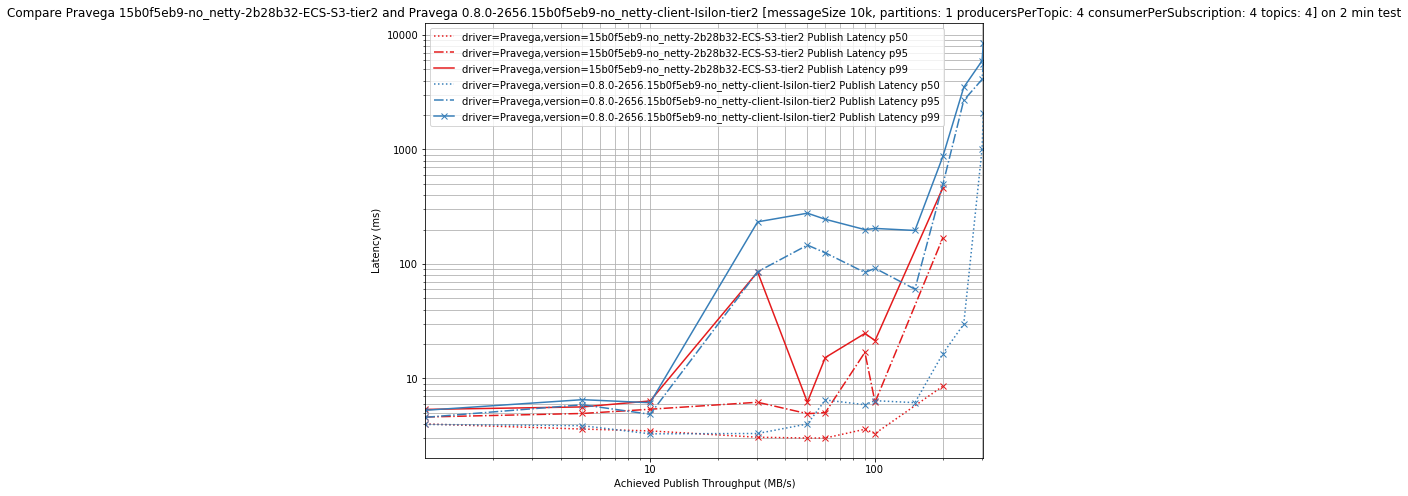

In [2288]:
plot_latency_vs_throughput_comparison([filt1_df, filt2_df], legend_cols=['driver', 'version'], latencyMetric='Publish')

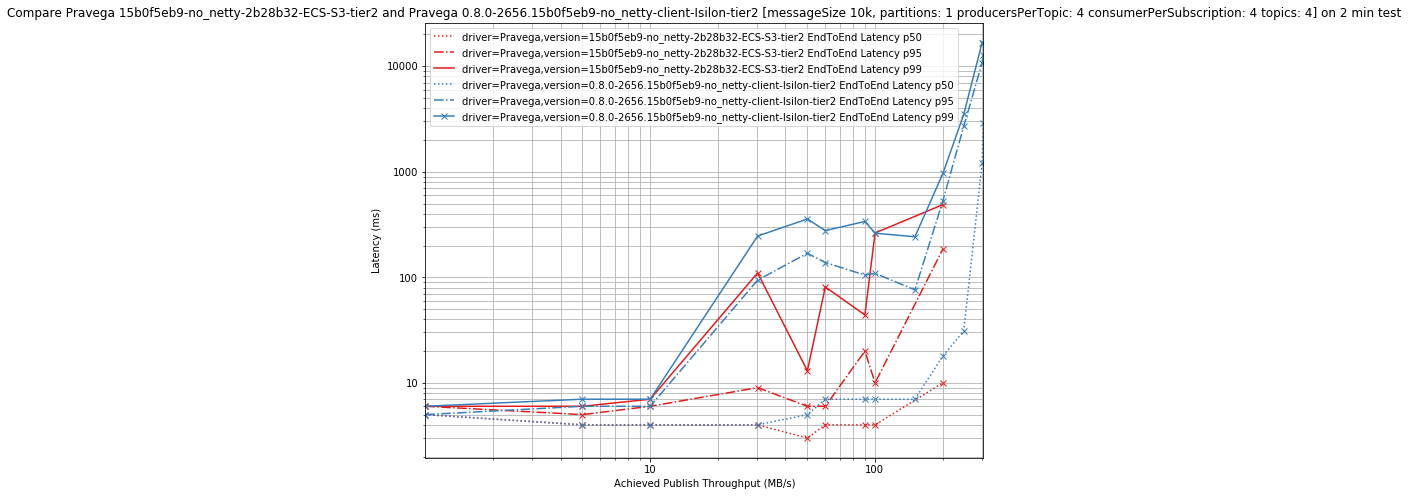

In [2289]:
plot_latency_vs_throughput_comparison([filt1_df, filt2_df], legend_cols=['driver', 'version'], latencyMetric='EndToEnd')

In [2290]:
### Latency vs Provided Rate 

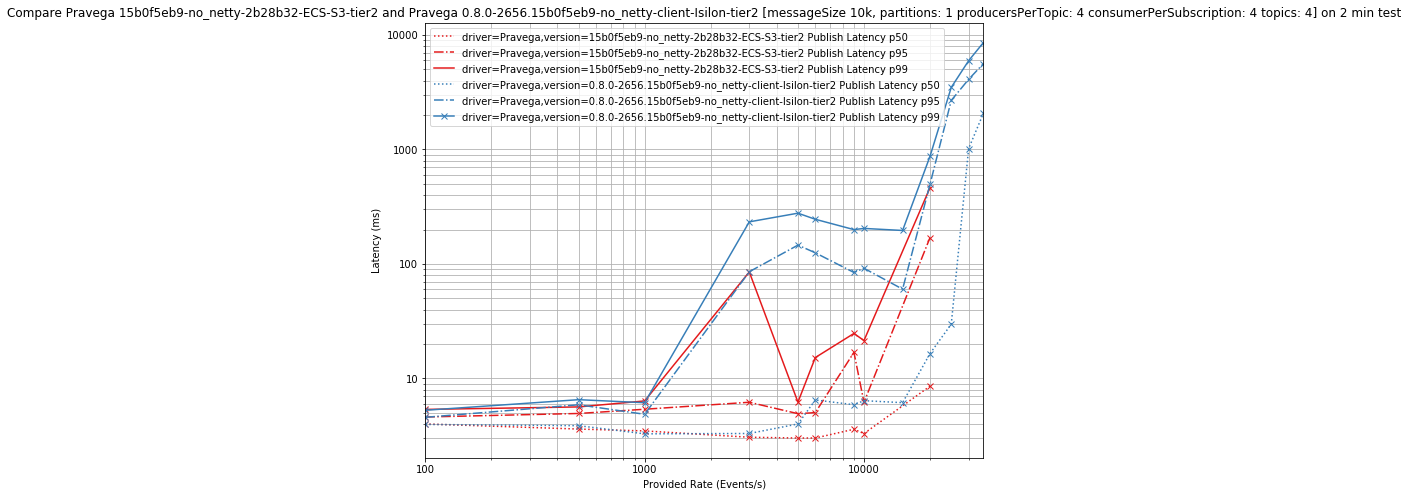

In [2291]:
plot_latency_vs_provided_rate_comparison([filt1_df, filt2_df], legend_cols=['driver', 'version'], latencyMetric='Publish')

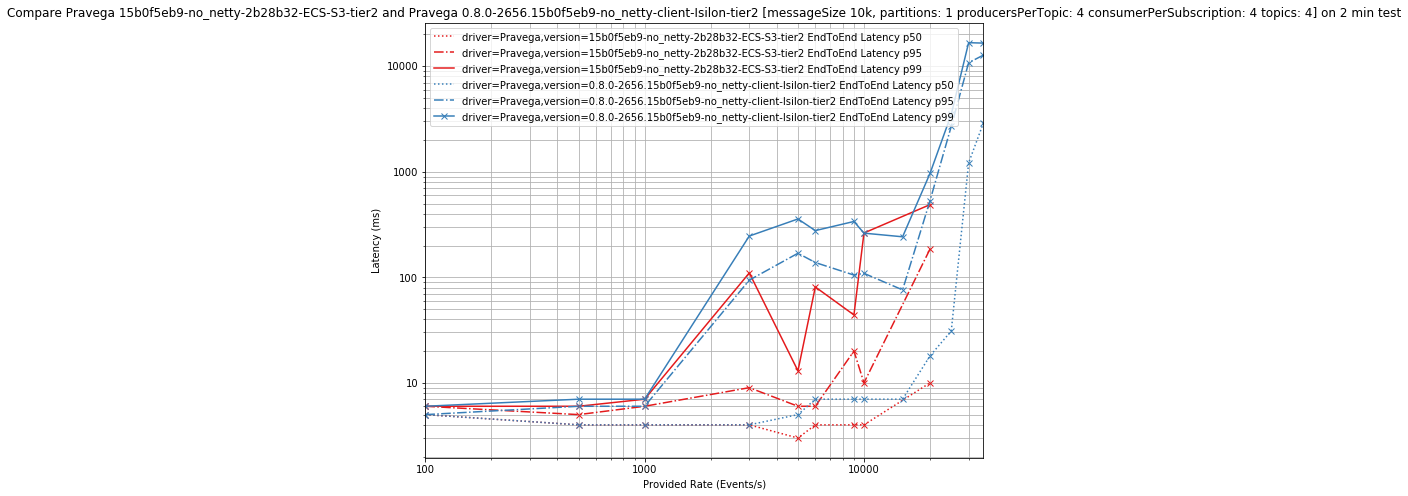

In [2287]:
plot_latency_vs_provided_rate_comparison([filt1_df, filt2_df], legend_cols=['driver', 'version'], latencyMetric='EndToEnd')